In [ ]:
+66import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
df_no_diagnosis=pd.read_csv("demographic_info.txt",names=['Patient number','Age','Sex','Adult BMI(kg/m2)','Child Weight (kg)','Child Height (cm)'],delimiter=' ')

diagnosis=pd.read_csv("Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv",names=['Patient number','Diagnosis'])

In [3]:
df=df_no_diagnosis.join(diagnosis.set_index('Patient number'), on='Patient number', how='left')

df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [4]:
df

,Patient number,Age,Sex,Adult BMI(kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.00,99.0,URTI
1,102,0.75,F,NaN,9.80,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.00,135.0,URTI
5,106,73.00,F,21.00,NaN,NaN,COPD
6,107,75.00,F,33.70,NaN,NaN,COPD
7,108,3.00,M,NaN,NaN,NaN,LRTI
8,109,84.00,F,33.53,NaN,NaN,COPD
9,110,75.00,M,25.21,NaN,NaN,COPD


In [ ]:
root = "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]


In [6]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [7]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,224,1b2,Al,sc,Meditron
0,225,1b1,Pl,sc,Meditron
0,226,1b1,Al,sc,Meditron
0,226,1b1,Ll,sc,Meditron
0,226,1b1,Pl,sc,LittC2SE


In [8]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [9]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

,filename
0,101_1b1_Al_sc_Meditron
1,101_1b1_Pr_sc_Meditron
2,102_1b1_Ar_sc_Meditron
3,103_2b2_Ar_mc_LittC2SE
4,104_1b1_Al_sc_Litt3200
5,104_1b1_Ar_sc_Litt3200
6,104_1b1_Ll_sc_Litt3200
7,104_1b1_Lr_sc_Litt3200
8,104_1b1_Pl_sc_Litt3200
9,104_1b1_Pr_sc_Litt3200


In [10]:
audio_path = "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"

In [11]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

  0%|          | 0/920 [00:00<?, ?it/s]

In [12]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('Healthy')

file_label_df['3 label diagnosis'] = diagnosis_3

In [13]:
file_label_df


,filename,Diagnosis,Patient Number,Chest Location,Acquisition Mode,Recording Equipment,3 label diagnosis
0,101_1b1_Al_sc_Meditron,URTI,101,Al,sc,Meditron,Non-Chronic Disease
1,101_1b1_Pr_sc_Meditron,URTI,101,Pr,sc,Meditron,Non-Chronic Disease
2,102_1b1_Ar_sc_Meditron,Healthy,102,Ar,sc,Meditron,Healthy
3,103_2b2_Ar_mc_LittC2SE,Asthma,103,Ar,mc,LittC2SE,Chronic Disease
4,104_1b1_Al_sc_Litt3200,COPD,104,Al,sc,Litt3200,Chronic Disease
5,104_1b1_Ar_sc_Litt3200,COPD,104,Ar,sc,Litt3200,Chronic Disease
6,104_1b1_Ll_sc_Litt3200,COPD,104,Ll,sc,Litt3200,Chronic Disease
7,104_1b1_Lr_sc_Litt3200,COPD,104,Lr,sc,Litt3200,Chronic Disease
8,104_1b1_Pl_sc_Litt3200,COPD,104,Pl,sc,Litt3200,Chronic Disease
9,104_1b1_Pr_sc_Litt3200,COPD,104,Pr,sc,Litt3200,Chronic Disease


In [14]:
file_label_df['Diagnosis'].value_counts()


COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: Diagnosis, dtype: int64

In [15]:
file_label_df['3 label diagnosis'].value_counts()


Chronic Disease        810
Non-Chronic Disease     75
Healthy                 35
Name: 3 label diagnosis, dtype: int64

In [16]:
#exploratory data analysis
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [17]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
sound_filename

'Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/124_1b1_Al_sc_Litt3200.wav'

In [18]:
import IPython.display as ipd
ipd.Audio(sound_filename,rate=16000)

c:\users\pavan vatturi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Pass y=[6.05557289e-05 7.68980972e-05 8.29516284e-05 ... 1.55569529e-02
 1.01547465e-02 4.80424426e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error


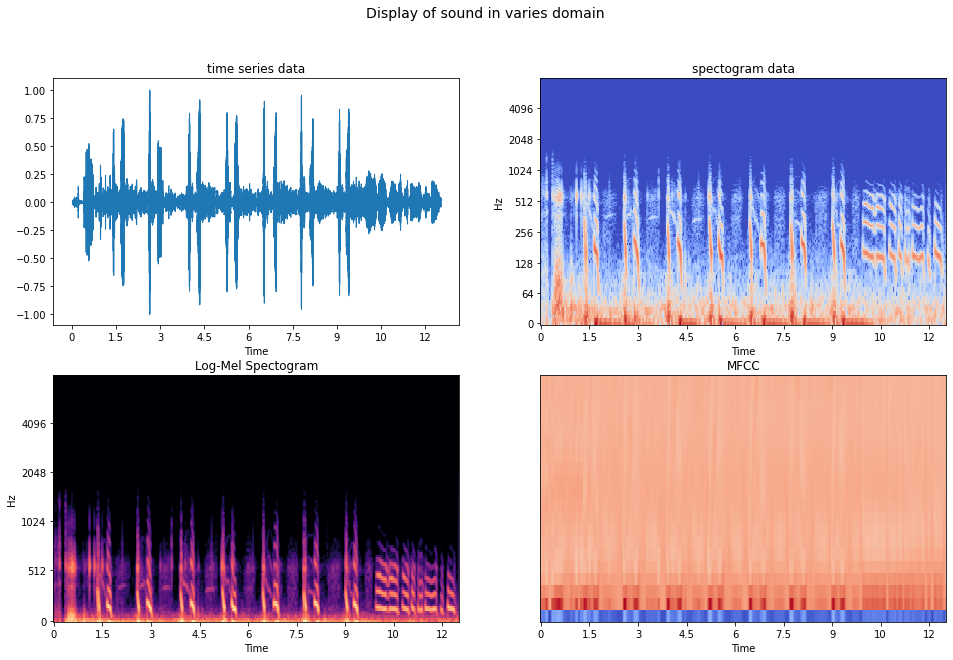

In [19]:
# Displaying sound data 
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);


In [20]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [21]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [22]:
labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)

  0%|          | 0/920 [00:00<?, ?it/s]

In [23]:
preprocessed_data[0].shape

(20, 157)

In [24]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [25]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels) 

encoder_3 = LabelEncoder()
i_labels_3 = encoder_3.fit_transform(labels_3)
oh_labels_3 = to_categorical(i_labels_3) 

In [26]:
print(list(encoder_3.classes_))

['Chronic Disease', 'Healthy', 'Non-Chronic Disease']


In [27]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels_3, stratify=oh_labels_3, test_size=0.2, random_state = 42)

In [28]:
#training
from tensorflow.keras.layers import BatchNormalization

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels_3.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 156, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 78, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 9, 78, 16)         0         
                                                                 
 dense (Dense)               (None, 9, 78, 64)         1088      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 77, 32)         8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 38, 32)        0         
 2D)                                                    

In [29]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [30]:
# train model
num_epochs = 100
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 2.3345 - accuracy: 0.7785
Epoch 1: val_accuracy improved from -inf to 0.24457, saving model to mymodel2_01.h5
12/12 [==============================] - 5s 213ms/step - loss: 2.3345 - accuracy: 0.7785 - val_loss: 1.4130 - val_accuracy: 0.2446
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.7688 - accuracy: 0.8125
Epoch 2: val_accuracy improved from 0.24457 to 0.88043, saving model to mymodel2_02.h5
12/12 [==============================] - 2s 156ms/step - loss: 0.7688 - accuracy: 0.8125 - val_loss: 0.4704 - val_accuracy: 0.8804
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.8505
Epoch 3: val_accuracy did not improve from 0.88043
12/12 [==============================] - 2s 147ms/step - loss: 0.5952 - accuracy: 0.8505 - val_loss: 0.5666 - val_accuracy: 0.8804
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8750
Epoch

Epoch 30/100
12/12 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.8899
Epoch 30: val_accuracy did not improve from 0.90217
12/12 [==============================] - 2s 143ms/step - loss: 0.2738 - accuracy: 0.8899 - val_loss: 0.3424 - val_accuracy: 0.8967
Epoch 31/100
12/12 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8791
Epoch 31: val_accuracy did not improve from 0.90217
12/12 [==============================] - 2s 151ms/step - loss: 0.2885 - accuracy: 0.8791 - val_loss: 0.3424 - val_accuracy: 0.8696
Epoch 32/100
12/12 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8804
Epoch 32: val_accuracy did not improve from 0.90217
12/12 [==============================] - 2s 150ms/step - loss: 0.2740 - accuracy: 0.8804 - val_loss: 0.3289 - val_accuracy: 0.8804
Epoch 33/100
12/12 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.8845
Epoch 33: val_accuracy did not improve from 0.90217
12/12 [========

12/12 [==============================] - 2s 148ms/step - loss: 0.1737 - accuracy: 0.9348 - val_loss: 0.3326 - val_accuracy: 0.8913
Epoch 89/100
12/12 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9239
Epoch 89: val_accuracy did not improve from 0.90761
12/12 [==============================] - 2s 151ms/step - loss: 0.1799 - accuracy: 0.9239 - val_loss: 0.3242 - val_accuracy: 0.9022
Epoch 90/100
12/12 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9171
Epoch 90: val_accuracy did not improve from 0.90761
12/12 [==============================] - 2s 151ms/step - loss: 0.1746 - accuracy: 0.9171 - val_loss: 0.3617 - val_accuracy: 0.8859
Epoch 91/100
12/12 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9307
Epoch 91: val_accuracy did not improve from 0.90761
12/12 [==============================] - 2s 151ms/step - loss: 0.1706 - accuracy: 0.9307 - val_loss: 0.3522 - val_accuracy: 0.8859
Epoch 92/100
12/12 [============

In [31]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9198369383811951
Testing Accuracy:  0.89673912525177


In [32]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=3 # number of classes

In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Chronic Disease', 'Healthy', 'Non-Chronic Disease']

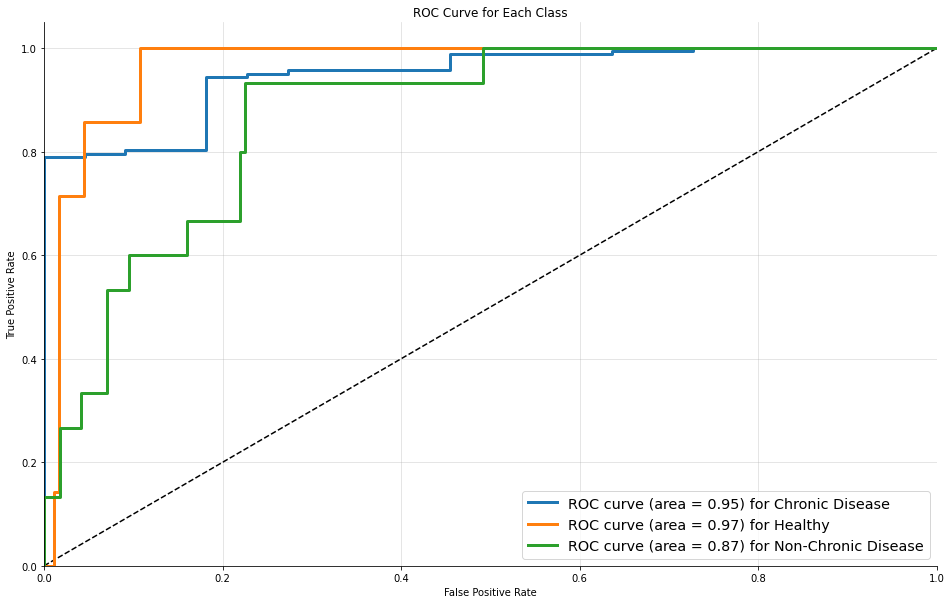

In [34]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [35]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                     precision    recall  f1-score   support

    Chronic Disease       0.94      0.98      0.96       162
            Healthy       0.33      0.14      0.20         7
Non-Chronic Disease       0.42      0.33      0.37        15

           accuracy                           0.90       184
          macro avg       0.56      0.49      0.51       184
       weighted avg       0.87      0.90      0.88       184



In [36]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[159   0   3]
 [  2   1   4]
 [  8   2   5]]


In [37]:
export_dir = 'saved_model/my_model'

tf.saved_model.save(model, export_dir=export_dir)

INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [47]:
# saving model in HDF5 format
model.save('prediction_lung_disease_model.h5')

In [ ]:
# load model
# Recreate the exact same model, including its weights and the optimizer
from tensorflow import keras

new_model = tf.keras.models.load_model("prediction_lung_disease_model.h5")

# Show the model architecture
new_model.summary()

In [ ]:
audio_path = 'Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
import numpy as np
import librosa

i = 12
audio_file = audio_path + file_label_df['filename'][i] + '.wav'

# preprocessing sound
data = preprocessing(audio_file, mode='mfcc')
data = np.array(data)
print(data.shape)
data = data.reshape((20, 157, 1))
data = np.expand_dims(data, axis=0)

datas = np.vstack([data])

# Predict sound data
classes = new_model.predict(datas, batch_size=10)
idx = np.argmax(classes)

c_names = ['Chronic Disease', 'Healthy', 'Non-Chronic Disease']
print('Lunion prediction: \n{}'.format(c_names[idx]))
print('Actual label: \n{}'.format(file_label_df['3 label diagnosis'][i]))
print('Confidence Percentage: {:.2f} %'.format(np.max(classes) * 100))